# Load Libraries

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import rcParams
import squidpy as sq
import PIL
import numpy as np
# import anndata as ad

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# Load Data Set

In [2]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 0 # 3 for more info

adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Filter Data

In [3]:
print(f"cells before MT filter: {adata.n_obs}")
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

cells before MT filter: 4035
cells after MT filter: 3861


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


# Sub sample down

In [4]:

def train_test_split(adata, train_frac=0.70):
    train_size = int(adata.shape[0] * train_frac)
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_data = adata[train_idx, :]
    valid_data = adata[test_idx, :]

    return train_data, valid_data

In [5]:
adata_subsample,adata_valid = train_test_split(adata)

# MLP

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [7]:
def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = np.zeros((d_model, height, width))
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = np.exp(np.arange(0., d_model, 2) *
                         -(np.log(10000.0) / d_model))
    pos_w = np.expand_dims(np.arange(0., width), axis=1)
    pos_h = np.expand_dims(np.arange(0., height), axis=1)
    pe[0:d_model:2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.sin(pos_w * div_term), 0, 1), axis=1), (1, height, 1))
    pe[1:d_model:2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.cos(pos_w * div_term), 0, 1), axis=1), (1, height, 1))
    pe[d_model::2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.sin(pos_h * div_term), 0, 1), axis=2), (1, 1, width))
    pe[d_model + 1::2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.cos(pos_h * div_term), 0, 1), axis=2), (1, 1, width))

    return pe

In [8]:
# Turn coordinates into positional encodings
coordinates = (adata_subsample.obsm["spatial"] / 100).astype(int)

max_range = coordinates.max(axis=0)
min_range = coordinates.min(axis=0)

encoding_dim = 128
p_enc_2d = positionalencoding2d(encoding_dim, int(max_range[0] - min_range[0]) + 1, int(max_range[1] - min_range[1]) + 1)
X = np.zeros((coordinates.shape[0], encoding_dim))
print(X.shape)
for idx, i in enumerate(coordinates):
    X[idx] = p_enc_2d[:, i[0] - min_range[0], i[1] - min_range[1]]

# Gene expression
y = adata_subsample[:, adata_subsample.var.highly_variable].X.A


# Split testing and training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42)

(2702, 128)


In [9]:
#Define Sequential model with 3 layers
model = keras.Sequential(
    [
        keras.Input(shape=(encoding_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(y.shape[1])
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 2000)              258000    
                                                                 
Total params: 307,536
Trainable params: 307,536
Non-trainable params: 0
_________________________________________________________________


2022-05-06 15:41:07.381827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Call model on a test input
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mse")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[callback], batch_size=8)

Epoch 1/100
321/321 [==============================] - 1s 2ms/step - loss: 0.1259 - val_loss: 0.1084
Epoch 2/100
321/321 [==============================] - 0s 1ms/step - loss: 0.1077 - val_loss: 0.1063
Epoch 3/100
321/321 [==============================] - 1s 2ms/step - loss: 0.1045 - val_loss: 0.1053
Epoch 4/100
321/321 [==============================] - 1s 2ms/step - loss: 0.1023 - val_loss: 0.1030
Epoch 5/100
321/321 [==============================] - 1s 2ms/step - loss: 0.1005 - val_loss: 0.1026
Epoch 6/100
321/321 [==============================] - 1s 2ms/step - loss: 0.0992 - val_loss: 0.1021
Epoch 7/100
321/321 [==============================] - 1s 2ms/step - loss: 0.0984 - val_loss: 0.1004
Epoch 8/100
321/321 [==============================] - 1s 2ms/step - loss: 0.0975 - val_loss: 0.1008
Epoch 9/100
321/321 [==============================] - 1s 2ms/step - loss: 0.0970 - val_loss: 0.1007
Epoch 10/100
321/321 [==============================] - 1s 2ms/step - loss: 0.0963 - val_lo

# Re rendering cells

In [11]:
x_cont = np.arange(0, p_enc_2d.shape[1]) + min_range[0]
y_cont = np.arange(0, p_enc_2d.shape[2]) + min_range[0]
xx, yy = np.meshgrid(x_cont, y_cont)
adata

AnnData object with n_obs × n_vars = 3861 × 19685
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [12]:
flatten_encoding = np.transpose(p_enc_2d.reshape(encoding_dim, -1))

print(flatten_encoding.shape)
output = model.predict(flatten_encoding)

mlp_Z = output.reshape(xx.shape[1], xx.shape[0], output.shape[1])

mlp_Z = np.flip(np.swapaxes(mlp_Z, 0, 1), 0)

print(mlp_Z.shape)

(7708, 128)
(94, 82, 2000)


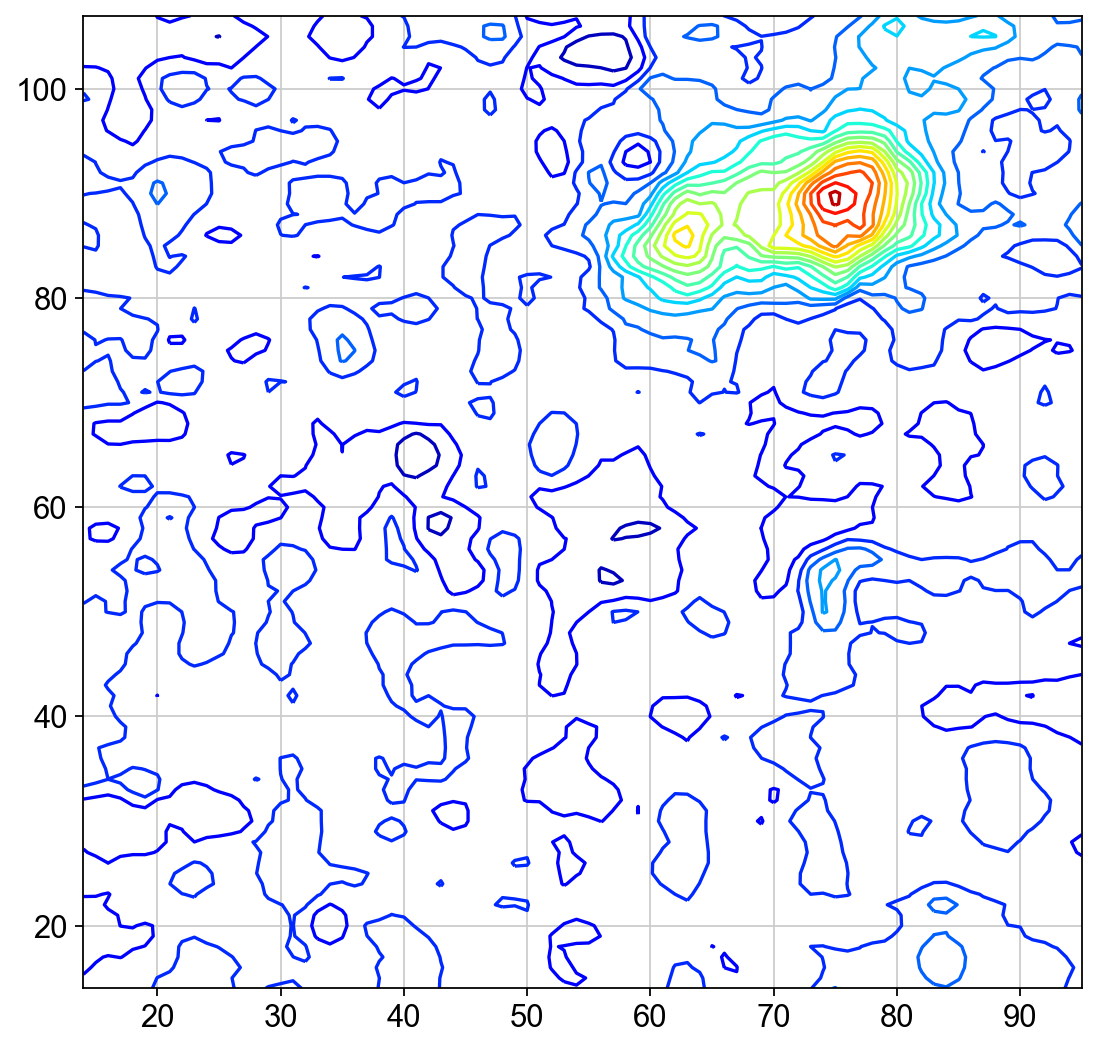

In [13]:
genes = adata_subsample.var.index[adata_subsample.var.highly_variable]
gene_name = genes[2]

plt.figure()
plt.contour(xx, yy, mlp_Z[:, :, np.where(genes == gene_name)[0][0]], 20, cmap='jet');
plt.show()



# Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


coordinates = (adata_subsample.obsm["spatial"] / 100).astype(int)

max_range = coordinates.max(axis=0)
min_range = coordinates.min(axis=0)

print(coordinates.shape)
X = np.zeros((coordinates.shape[0], 2))
print(X.shape)
for idx, i in enumerate(coordinates):
    X[idx] = [i[0] - min_range[0], i[1] - min_range[1]]

poly = PolynomialFeatures(4) #4 is best
X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

#alpha for polynomials of 1,3,5

height_range = range(0,int(max_range[0] - min_range[0]) + 1)
width_range = range(int(max_range[1] - min_range[1]) + 1)

val_cells = np.zeros((len(height_range)*len(width_range),2))

print(val_cells.shape)

cell_count = 0 

for height in height_range:
    for width in width_range:
        val_cells[cell_count]  = np.array([height,width])
        cell_count +=1

val_cells = poly.fit_transform(val_cells)

linear_output = reg.predict(val_cells)

#print(linear_output.shape)
linear_Z = linear_output.reshape(xx.shape[1], xx.shape[0], linear_output.shape[1])
linear_Z = np.flip(np.swapaxes(linear_Z, 0, 1), 0)


(2702, 2)
(2702, 2)
(7708, 2)


82


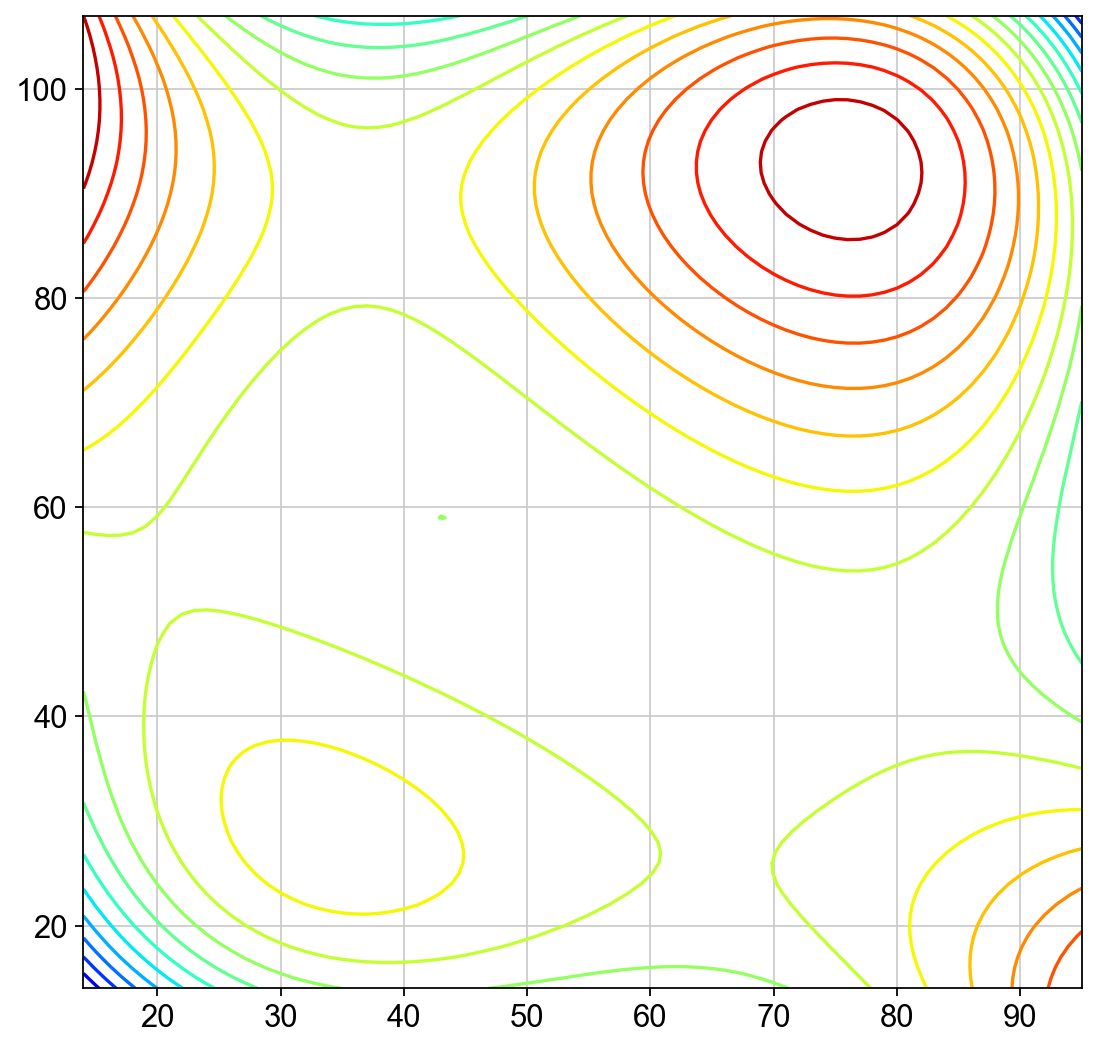

In [15]:
plt.figure()

print(linear_Z.shape[1])

x_cont = np.arange(0, linear_Z.shape[1]) + min_range[0]
y_cont = np.arange(0, linear_Z.shape[0]) + min_range[0]
xx, yy = np.meshgrid(x_cont, y_cont)

plt.contour(xx, yy, linear_Z[:, :, np.where(genes == gene_name)[0][0]], 20, cmap='jet')
plt.show()

# KNN

In [16]:
from sklearn.neighbors import KNeighborsRegressor

#k is 1, 5, 10, 30
coordinates = (adata_subsample.obsm["spatial"] / 100).astype(int)

max_range = coordinates.max(axis=0)
min_range = coordinates.min(axis=0)

print(coordinates.shape)
X = np.zeros((coordinates.shape[0], 2))
print(X.shape)
for idx, i in enumerate(coordinates):
    X[idx] = [i[0] - min_range[0], i[1] - min_range[1]]

y = adata_subsample[:, adata_subsample.var.highly_variable].X.A
knn = KNeighborsRegressor(n_neighbors=20).fit(X, y)

height_range = range(0,int(max_range[0] - min_range[0]) + 1)
width_range = range(0,int(max_range[1] - min_range[1]) + 1)

val_cells = np.zeros((len(height_range)*len(width_range),2))

print(val_cells.shape)

cell_count = 0 
for height in height_range:
    for width in width_range:
        val_cells[cell_count]  = np.array([height,width])
        cell_count +=1

print(val_cells[1000])


knn_output = knn.predict(val_cells)


#print(linear_output.shape)
knn_Z = knn_output.reshape(xx.shape[1], xx.shape[0], knn_output.shape[1])
knn_Z = np.flip(np.swapaxes(knn_Z, 0, 1), 0)

(2702, 2)
(2702, 2)
(7708, 2)
[10. 60.]


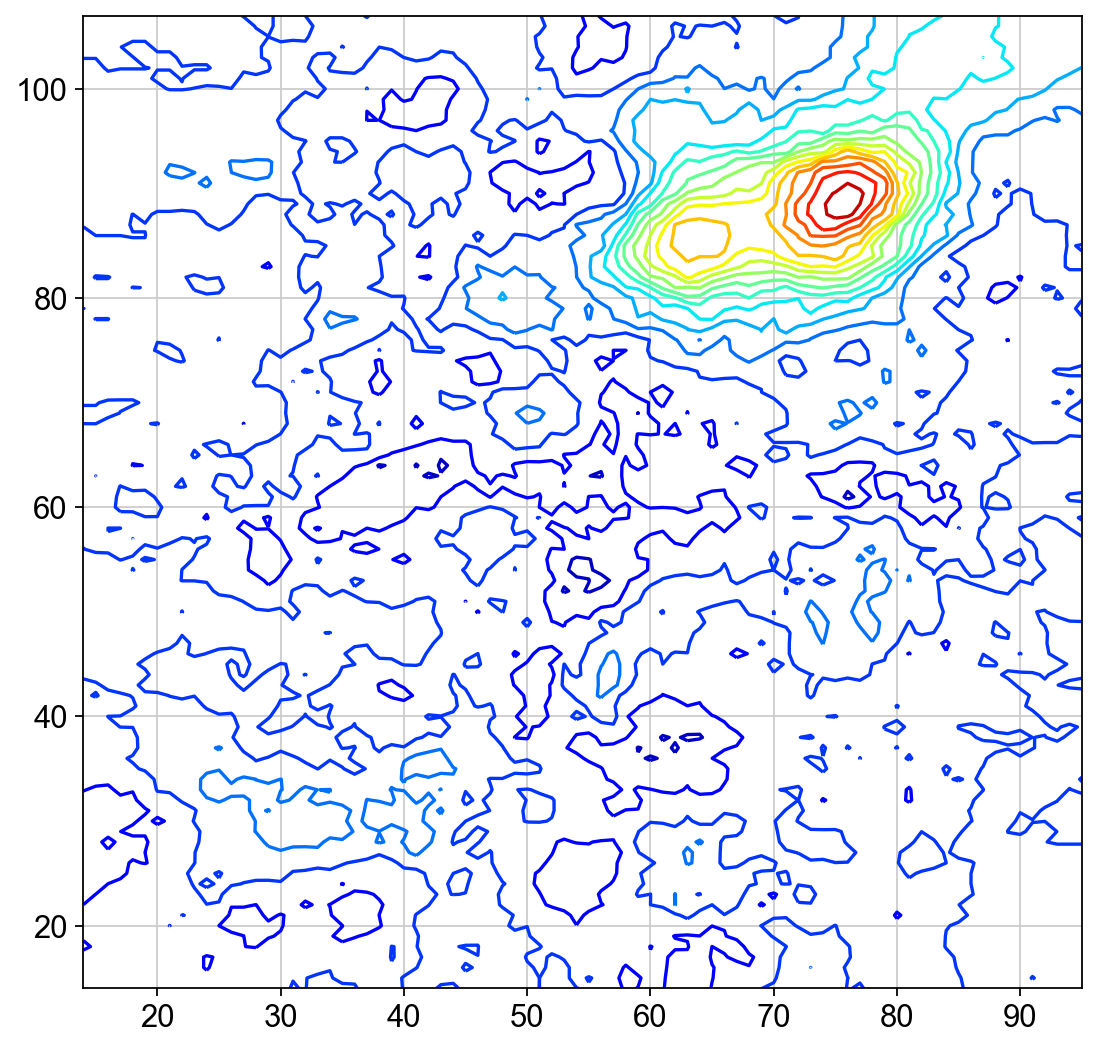

In [17]:
plt.figure()
plt.contour(xx, yy, knn_Z[:, :, np.where(genes == gene_name)[0][0]], 20, cmap='jet')
plt.show()

# Comparing Accuracy

In [18]:

from sklearn.metrics import mean_squared_error


valid_coordinates = (adata_valid.obsm["spatial"] / 100).astype(int)
truth_genes = adata_valid[:, adata_valid.var.highly_variable].X.A

knn_validation = knn.predict(valid_coordinates)

poly = PolynomialFeatures(4)
poly_coordinates = poly.fit_transform(valid_coordinates)

linear_validation = reg.predict(poly_coordinates)


max_range = valid_coordinates.max(axis=0)
min_range = valid_coordinates.min(axis=0)

encoding_dim = 128
p_enc_2d = positionalencoding2d(encoding_dim, int(max_range[0] - min_range[0]) + 1, int(max_range[1] - min_range[1]) + 1)
X = np.zeros((valid_coordinates.shape[0], encoding_dim))
for idx, i in enumerate(valid_coordinates):
    X[idx] = p_enc_2d[:, i[0] - min_range[0], i[1] - min_range[1]]

mlp_validation = model.predict(X)


print(f" KNN MSE: {mean_squared_error(knn_validation,truth_genes)}")
print(f" Linear MSE: {mean_squared_error(linear_validation,truth_genes)}")
print(f" MLP MSE: {mean_squared_error(mlp_validation,truth_genes)}")



 KNN MSE: 0.11990287899971008
 Linear MSE: 0.12566168456324944
 MLP MSE: 0.09769914299249649
